# Análise da reincidência por cliente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import math

In [2]:
all_orders = pd.read_csv('../datasets/trusted/all_orders.csv')
all_orders.count()

Unnamed: 0                       99441
order_id                         99441
customer_unique_id               99441
customer_city                    99441
customer_state                   99441
order_approved_at                99281
order_purchase_timestamp         99441
order_estimated_delivery_date    99441
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
dtype: int64

In [3]:
times_bought = all_orders.groupby(['customer_unique_id']).agg('count')['order_id'].sort_values(ascending=False)
times_bought.head(10)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
63cfc61cee11cbe306bff5857d00bfe4     6
47c1a3033b8b77b3ab6e109eb4d5fdf3     6
dc813062e0fc23409cd255f7f53c7074     6
de34b16117594161a6a89c50b289d35a     6
f0e310a6839dce9de1638e0fe5ab282a     6
Name: order_id, dtype: int64

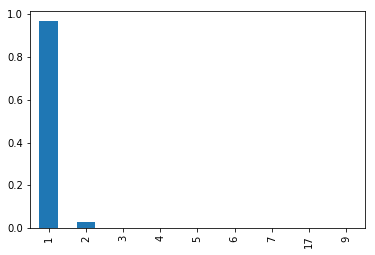

In [4]:
times_bought.value_counts(normalize=True).plot.bar()

Como é possível observar com o gráfico, a grande maioria dos clientes compra apenas uma vez.

In [5]:
more_than_once = all_orders.loc[np.where(times_bought > 1)]
more_than_once.count()

Unnamed: 0                       2997
order_id                         2997
customer_unique_id               2997
customer_city                    2997
customer_state                   2997
order_approved_at                2992
order_purchase_timestamp         2997
order_estimated_delivery_date    2997
order_delivered_carrier_date     2953
order_delivered_customer_date    2917
dtype: int64

## Hipótese: a região dos consumidores afeta se eles voltam a comprar ou não

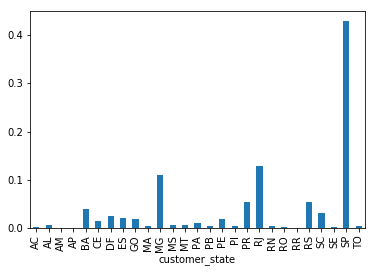

In [6]:
mto_by_state = more_than_once.groupby(['customer_state']).agg('count')['order_id']
(mto_by_state / more_than_once.count()[0]).plot.bar()

A maior parte dos clientes que volta é do estado de são paulo.

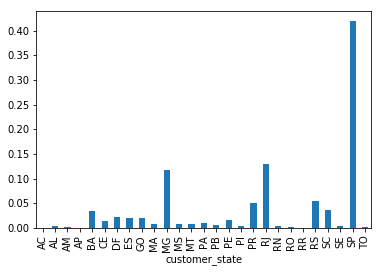

In [7]:
all_by_state = all_orders.groupby(['customer_state']).agg('count')['order_id']
(all_by_state / all_orders.count()[0]).plot.bar()

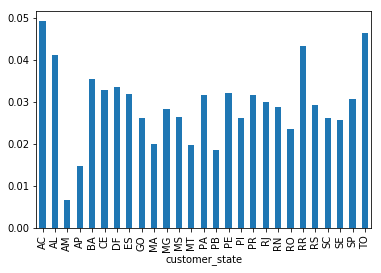

In [8]:
(mto_by_state / all_by_state).plot.bar()

In [9]:
pd.DataFrame({'mto': mto_by_state, 'all': all_by_state }).corr()['mto']['all']

0.9994653387646663

In [10]:
print(stats.kruskal(all_by_state / all_orders.count()[0], mto_by_state / more_than_once.count()[0]).pvalue * 100, '%', sep='')

88.30838631048043%


Fazendo uma análise da quantidade de clientes por estado, porém, percebe-se que a distribuição é quase exatamente a mesma. O P-Value para o teste de kruskal também é alto, indicando alta probabilidade de que a distribuição é idêntica.

É razoável assumir que o estado não tem nenhum tipo de efeito em se o cliente volta a comprar ou não.

## Hipótese: o atraso nas entregas afetam se as pessoas voltam ou não

In [11]:
def delivery_delay(order):
    estimated = pd.to_datetime(order['order_estimated_delivery_date'])
    delivered = pd.to_datetime(order['order_delivered_customer_date'])
    return delivered - estimated

In [12]:
delays_in_days_mto = delivery_delay(more_than_once) / np.timedelta64(24, 'h')
delays_in_days_all = delivery_delay(all_orders) / np.timedelta64(24, 'h')

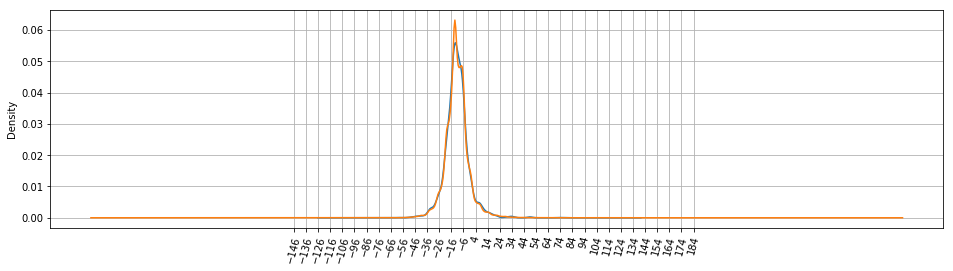

In [13]:
delays_in_days_mto.plot.kde(
    figsize=(16, 4),
    xticks=range(int(delays_in_days_mto.min()),
                 int(delays_in_days_mto.max()),
                 10),
    rot=75,
    grid=True)

delays_in_days_all.plot.kde(
    figsize=(16, 4),
    xticks=range(int(delays_in_days_all.min()),
                 int(delays_in_days_all.max()),
                 10),
    rot=75,
    grid=True)

In [14]:
ddmto = delays_in_days_mto.dropna().map(lambda x:math.trunc(x)).value_counts(normalize=True).sort_index()
ddmto.describe()

count    82.000000
mean      0.012195
std       0.018102
min       0.000343
25%       0.000686
50%       0.003085
75%       0.015598
max       0.071992
dtype: float64

In [15]:
ddall = delays_in_days_all.dropna().map(lambda x:math.trunc(x)).value_counts(normalize=True)[ddmto.index].sort_index()
ddall.describe()

count    82.000000
mean      0.012111
std       0.017925
min       0.000021
25%       0.000697
50%       0.002679
75%       0.017473
max       0.073863
dtype: float64

In [16]:
stats.kruskal(ddmto.values, ddall.values).pvalue

0.6759162116277826

A maioria das entregas para clientes que voltam acontecem dentro do prazo estipulado, e em sua maior parte adiantadas, com o pico no KDE no valor de -12 dias de "atraso", ou seja, 12 dias adiantado.

Para o total das entregas, no entanto, observa-se o mesmo padrão. Simultaneamente, o teste de Kruskal-Wallis apresenta um elevado p-value de 68%, o que indica que há uma boa chance de que as datas previstas e as datas de entrega apresentem a mesma distribuição tanto para a primeira compra quanto para os retornos. É possível que as entregas adiantadas não sejam a causa da volta dos clientes para mais compras.

## Hipótese: algumas categorias de produto apresentam maior taxa de reincidência do que outras

In [17]:
products = pd.read_csv('../datasets/trusted/sold_products.csv')
products.count()

Unnamed: 0                       104881
product_id                       104881
order_id                         104881
price                            104881
freight_value                    104881
order_purchase_timestamp         104881
order_estimated_delivery_date    104881
order_delivered_carrier_date     104881
order_delivered_customer_date    104881
product_category_name            104881
product_name_lenght              104881
product_description_lenght       104881
product_photos_qty               104881
product_weight_g                 104881
product_length_cm                104881
product_height_cm                104881
product_width_cm                 104881
dtype: int64

In [18]:
columns = ['customer_unique_id', 'order_id', 'product_category_name']
orders_by_category = pd.merge(all_orders, products, on='order_id')[columns].rename(columns={
    'customer_unique_id': 'id',
    'product_category_name': 'category'
}).dropna()
orders_by_category.count()

id          104881
order_id    104881
category    104881
dtype: int64

In [19]:
orders_by_category.groupby('id').agg('count')['order_id'].sort_values(ascending=False).head()

id
c8460e4251689ba205045f3ea17884a1    24
4546caea018ad8c692964e3382debd19    21
c402f431464c72e27330a67f7b94d4fb    20
698e1cf81d01a3d389d96145f7fa6df8    20
0f5ac8d5c31de21d2f25e24be15bbffb    18
Name: order_id, dtype: int64

In [20]:
categories = sorted(products['product_category_name'].unique())
print(''.join(map(lambda c: c.ljust(60), categories)))

agro_industria_e_comercio                                   alimentos                                                   alimentos_bebidas                                           artes                                                       artes_e_artesanato                                          artigos_de_festas                                           artigos_de_natal                                            audio                                                       automotivo                                                  bebes                                                       bebidas                                                     beleza_saude                                                brinquedos                                                  cama_mesa_banho                                             casa_conforto                                               casa_conforto_2                                             casa_construcao                         

In [21]:
customers_by_category = orders_by_category.groupby(['category', 'id']).agg('count')
customers_by_category.head()

order_id
category                  id                                        
agro_industria_e_comercio 01a17507586f0f10f52e7e86ac73e1f7         1
                          0205ecc1296100f97f4ae03e22643b8e         1
                          03a4abdc6deb7b5b3c18b4cde6d63761         1
                          06944904bd31234a78668f4bb962817d         1
                          089c00c6a00d268888c4b66b6ec0c474         1

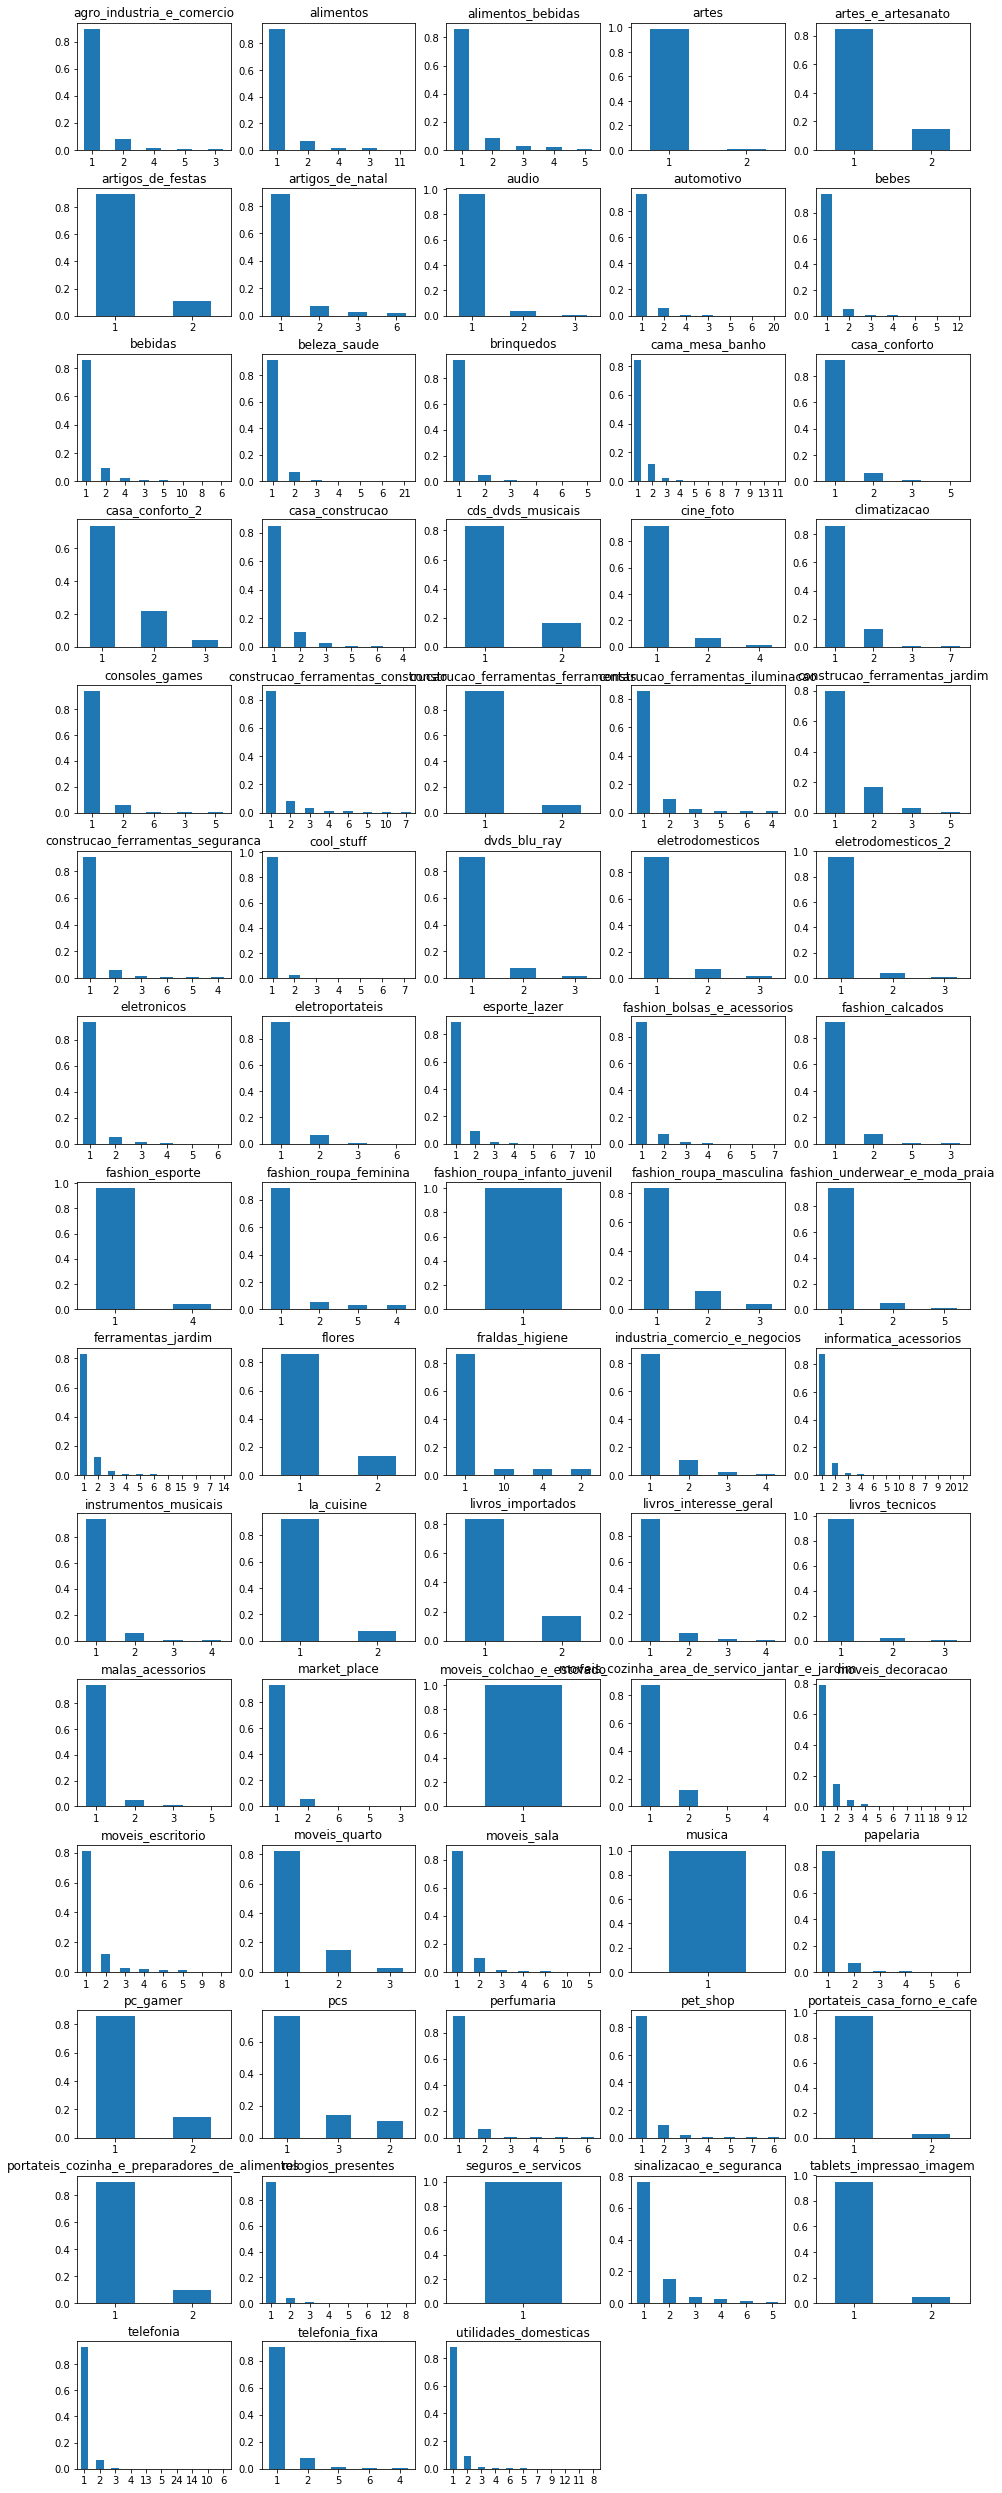

In [22]:
plt.figure(figsize=(16, 45))
plt.tight_layout()
plt.subplots_adjust(hspace=.3)

recurrence_by_category = pd.DataFrame(columns=['category', 'rate'])

for c in range(len(categories)):
    plt.subplot(15, 5, c + 1)
    customers = customers_by_category.loc[categories[c]].index
    orders_by_customers = all_orders[all_orders['customer_unique_id'].isin(customers.values)]
    sales_by_category = customers_by_category.loc[categories[c]].order_id
    
    recurrence_by_category.loc[categories[c]] = [
        categories[c],
        sales_by_category[sales_by_category.values > 2].count() / sales_by_category.count()
    ]
    
    plt.title(categories[c])
    sales_by_category.value_counts(normalize=True).plot.bar(rot=0)
    #print(sales_by_category.head())
    
plt.show()

In [23]:
recurrence_by_category.sort_values(by='rate', ascending=False).head()

,category,rate
pcs,pcs,0.137931
fraldas_higiene,fraldas_higiene,0.086957
sinalizacao_e_seguranca,sinalizacao_e_seguranca,0.086614
moveis_escritorio,moveis_escritorio,0.066606
moveis_decoracao,moveis_decoracao,0.066444


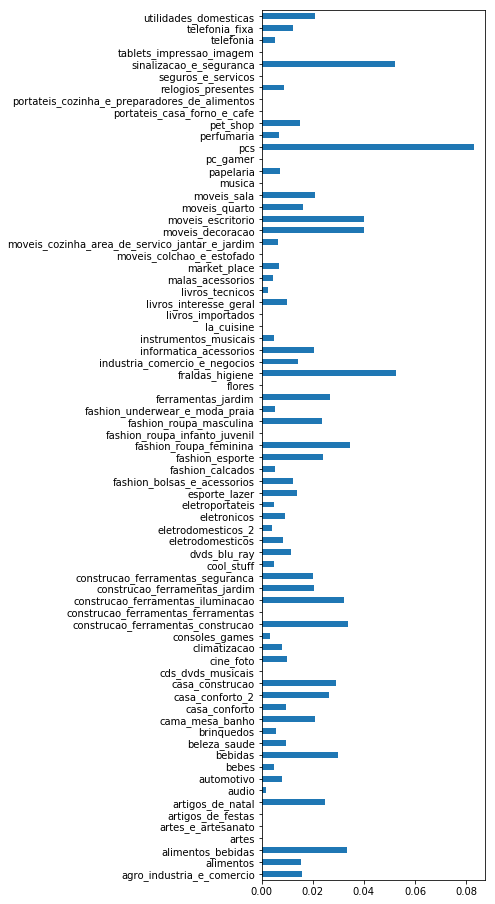

In [24]:
recurrence_distribution = (recurrence_by_category['rate'] / recurrence_by_category['rate'].sum()).sort_index()
recurrence_distribution.plot.barh(figsize=(4, 16))

In [25]:
print(recurrence_distribution.std() / recurrence_distribution.mean() * 100, '%', sep='')

111.56223366803192%


Visto que o desvio padrão é alto (111% da média), parece que, realmente, algumas categorias têm mais recorrência que outras.

<BarContainer object of 73 artists>

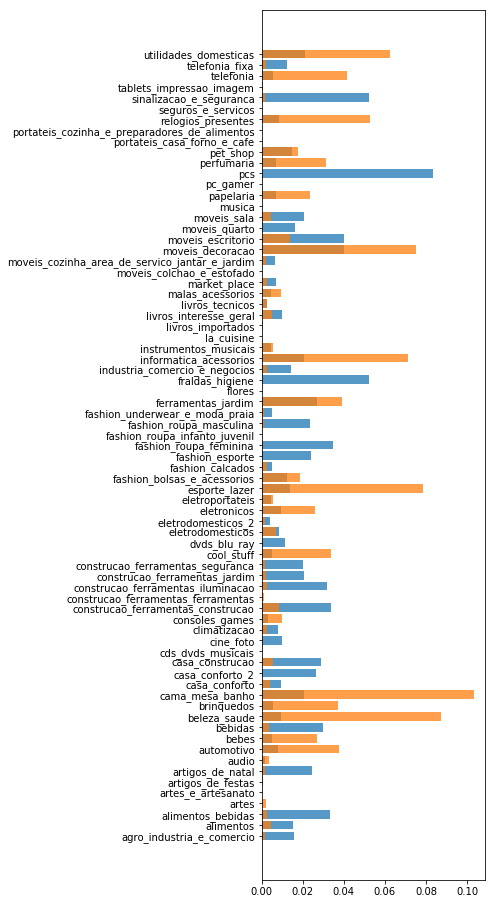

In [26]:
sales_by_category = orders_by_category.groupby('category').agg('count')['id']
sales_distribution = (sales_by_category / sales_by_category.sum()).sort_index()

plt.figure(figsize=(4, 16))
plt.barh(categories, recurrence_distribution, alpha=0.75)
plt.barh(categories, sales_distribution, alpha=0.75)

In [27]:
print(stats.kruskal(recurrence_distribution, sales_distribution).pvalue * 100, '%', sep='')

11.951872343331559%


O p-value de 11% indica que provavelmente a recorrência de compras entre as categorias não segue a mesma distribuição que o volume de compras.

Um maior volume de dados e uma janela de tempo mais abrangente ajudariam a dar respostas mais conclusivas nesse aspecto.

## Hipótese: Compras em uma categoria levam a compras em outras categorias

In [28]:
products_by_customer = pd.merge(
    all_orders[['order_id', 'customer_unique_id']],
    products[['order_id', 'product_category_name']]).groupby(
    ['customer_unique_id', 'product_category_name']).agg('count')

products_by_customer.head()

,,order_id
customer_unique_id,product_category_name,
0000366f3b9a7992bf8c76cfdf3221e2,cama_mesa_banho,1
0000b849f77a49e4a4ce2b2a4ca5be3f,beleza_saude,1
0000f46a3911fa3c0805444483337064,papelaria,1
0000f6ccb0745a6a4b88665a16c9f078,telefonia,1
0004aac84e0df4da2b147fca70cf8255,telefonia,1


In [29]:
category_sales_table = pd.DataFrame(columns=categories, index=categories).fillna(0)

for c1 in categories:
    customers_c1 = customers_by_category.loc[c1]
    #category_sales_table.loc[c1][c1] = customers_c1[customers_c1 > 1].count()
    
    for c2 in categories:
        if c1 == c2:
            continue
        customers_c2 = customers_by_category.loc[c2]
        category_sales_table.loc[c1][c2] = customers_c1[customers_c1.index.isin(customers_c2.index)].size

In [30]:
relation_table = pd.DataFrame({
    'most_common': category_sales_table.idxmax(),
    'max': category_sales_table.max()
})
relation_table.head()

,most_common,max
agro_industria_e_comercio,moveis_decoracao,1
alimentos,esporte_lazer,5
alimentos_bebidas,esporte_lazer,5
artes,moveis_decoracao,6
artes_e_artesanato,brinquedos,1


<BarContainer object of 19 artists>

<Figure size 288x1152 with 0 Axes>

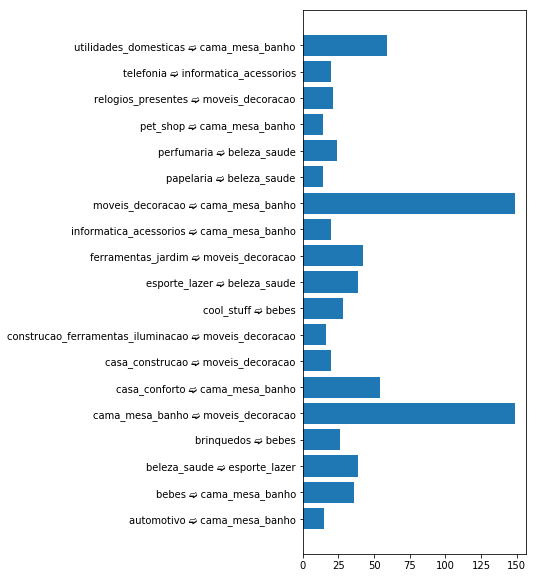

In [31]:
plt.figure(figsize=(4, 16))
above_average = relation_table[(relation_table['max'] > relation_table['max'].mean())]

above_avg_cats = above_average.index.tolist()
above_avg_dogs = above_average['most_common'].values.tolist()

plt.figure(figsize=(4, 10))
plt.barh(
    [' ➫ '.join(cat) for cat in zip(above_avg_cats, above_avg_dogs)],
    above_average['max'].values
)

In [32]:
category_sales_table.style.background_gradient(cmap='viridis')

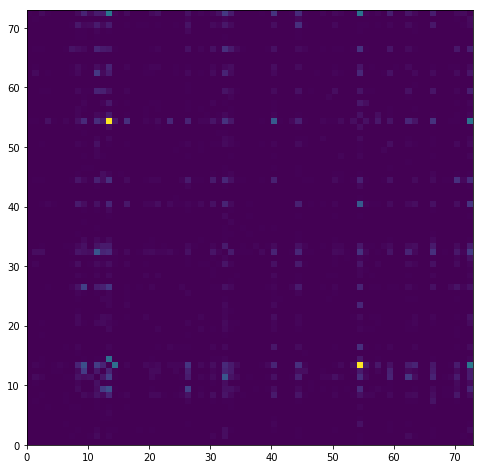

In [33]:
import matplotlib.colors as colors

plt.figure(figsize=(8, 8))
plt.pcolormesh(category_sales_table)

In [34]:
max_cat = category_sales_table.max().idxmax()
max_cat

'cama_mesa_banho'

In [35]:
max_dog = category_sales_table.loc[max_cat].idxmax()
max_dog

'moveis_decoracao'

A figura mostra um mapa de calor das compras entre categorias (cada linha e coluna é uma categoria). Cores mais claras indicam mais compras feitas por clientes em comum entre duas categorias.

É possível notar pela figura que algumas categorias têm relações com outras, mas a maioria não se relaciona. Isso é positivo para a relevância de um recomendador de conteúdo, por exemplo, visto que se todas as categorias se relacionassem da mesma forma não haveriam recomendações significativas, bem como se nenhuma tivesse relação não seria possível estabelecer padrões para recomendar produtos.

Os pontos mais claros no gráfico são da categoria `cama_mesa_banho` com `moveis_decoracao`, e apresentam uma quantidade de compras bem acima da média.

Se redefinirmos esses pontos para a média (para fins de observação apenas), o resto do gráfico apresenta valores mais nítidos.

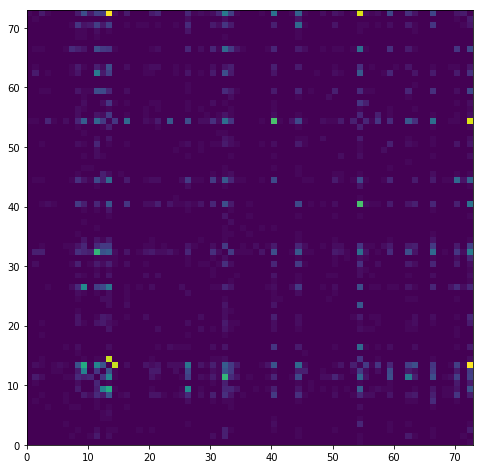

In [41]:
import matplotlib.colors as colors

category_sales_table_ = category_sales_table.copy()
category_sales_table_.loc[max_cat, max_dog] = category_sales_table_.mean().mean()
category_sales_table_.loc[max_dog, max_cat] = category_sales_table_.mean().mean()

plt.figure(figsize=(8, 8))
plt.pcolormesh(category_sales_table_)

In [37]:
# plt.figure(figsize=(16, 180))
# plt.tight_layout()
# plt.subplots_adjust(hspace=.1)

# for c in range(len(categories)):
#     rel = category_sales_table.iloc[c]
    
#     plt.title(rel.index[c])
#     plt.subplot(19, 8, c * 2 + 1)
    
#     if rel.max() == 0:
#         continue

#     rel[rel > 0].plot.barh()
    
# plt.show()

In [38]:
category_sales_table.max().std()

26.343865300388103

<BarContainer object of 73 artists>

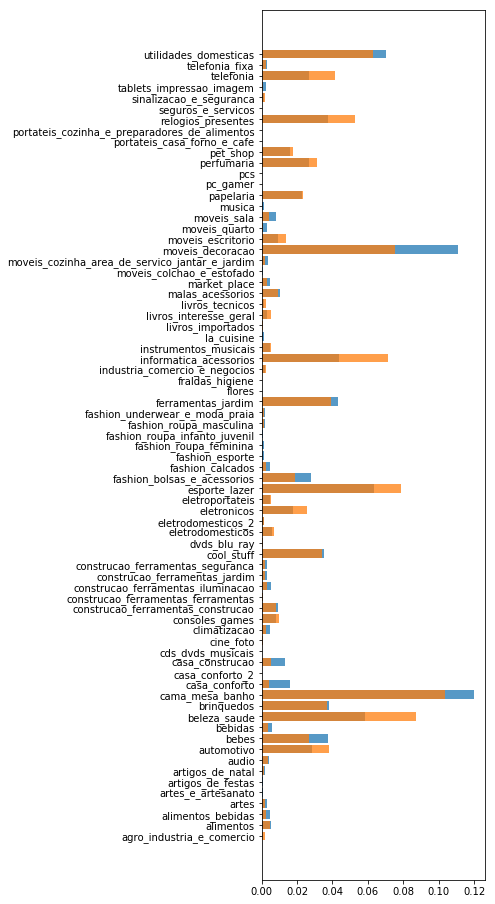

In [43]:
pointed_to = category_sales_table.sum()
pointed_to_distribution = (pointed_to / pointed_to.sum())

plt.figure(figsize=(4, 16))
plt.barh(categories, pointed_to_distribution, alpha=0.75)
plt.barh(categories, sales_distribution, alpha=0.75)

In [40]:
print(stats.kruskal(pointed_to_distribution, sales_distribution).pvalue * 100, '%', sep='')

45.8242603233784%


Hipotetizamos que a maior taxa de reincidência de algumas categorias se deve a maior popularidade delas. Aplicando o teste de Kruskal-Wallis, porém, obtemos um _pvalue_ de 45.8%, o que indica que esses dois valores não seguem a mesma distribuição, apesar de não ser possível afirmar com precisão se são totalmente independentes.

Com isso, podemos concluir que é provável, sim, que seja possível fazer recomendações de produtos baseado 